## Machine Learning : Theory and Applications (2025/26)
Simona Cocco & Vito Dichio

[✉ simona.cocco@phys.ens.fr](mailto:simona.cocco@phys.ens.fr) \\
[✉ vito.dichio@phys.ens.fr](mailto:vito.dichio@phys.ens.fr)


#### Bibliography:
[1] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022)

[2] de Ruyter van Steveninck et al., *Reproducibility and Variability in Neural Spike Trains*, Science 275, 1805–1808 (1997)

[3] Koch et al., *Efficiency of Information Transmission by Retinal Ganglion Cells*, Current Biology 14, 1523–1530 (2004)

[4] Schneidman et al., *Weak pairwise correlations imply strongly correlated network states in a neural population*, Nature 440, 7087 (2006)

[5] Cover & Thomas, *Elements of information theory*. John Wiley & Sons (1999)

# ML for Neuroscience — Tutorial 2 (SOLUTION)

**Topic:** Entropy and information in neural spike trains

**Goals**
- Define and compute entropy for discrete distributions (in bits)
- Bin spike trains and encode responses as binary words
- Estimate *total entropy* and *noise entropy* and mutual information 

**Note** / The present notebook is based on the *Tutorial 2: entropy and information in neural spike trains* in [1], Section 2.4. An additional general reference for the mathematical background is also [5], Chapter 2.

## Part A - Entropy of a Poisson spike train

Consider a single neuron whose spikes follow a Poisson process with constant rate $\theta$.  Let $N$ be the random variable denoting the number of spikes observed in a time window of length $T$.  Then $N$ is Poisson-distributed (see Tutorial 1):

$$
P_N(k \mid \lambda) = \Pr[N = k \mid \lambda]
= \frac{\lambda^k e^{-\lambda}}{k!}, \quad k=0,1,2,\dots
$$

where $\lambda = \theta T$ is the **expected number of spikes** in the window.

To analyze the spike train in a way that connects to information-theoretic quantities, we discretize the continuous time axis into non-overlapping bins of length $\Delta t$.

#### 🎯 Question A1.
Let $\sigma \in \{0,1\}$ be the binary random variable defined for each bin of length $\Delta t$ as follows: $\sigma=0$ if there are no spikes in the bin, $\sigma=1$ if there is **at least** one spike. This coarse-graining reduces the spike train to a binary sequence, which we can now analyze in terms of information content.

Compute analytically:

(i) the probability distribution $P_\sigma$ as functions of $\theta$ and $\Delta t$. 

(ii) the entropy $S(P_{\sigma})$ of the binary distribution $P_{\sigma}$ and the entropy rate $S(P_{\sigma})/\Delta t$ (in bits per second)


#### Solution A1.

(i) The random variable $\sigma$ can take two values: 0 (no spikes in the bin) and 1 (at least one spike in the bin). The probabilities are:

$P_{\sigma}(0) = P_N(0 | \lambda) = e^{- \lambda}\ ,$

$P_{\sigma}(1) = 1 - P_N(0 |  \lambda) = 1 - e^{- \lambda}\ ,$

where $\lambda = \theta \Delta t$ is the expected number of spikes in the bin of length $\Delta t$.

(ii) By definition, the entropy of a discrete distribution $P_{\sigma}$ is
$$ S(P_{\sigma}) = -  P_{\sigma}(0) \log P_{\sigma}(0) -P_{\sigma}(1) \log P_{\sigma}(1) = \theta \Delta t  e^{-  \theta \Delta t} - (1-e^{-  \theta \Delta t})\log(1-e^{-  \theta \Delta t})$$
The entropy rate is the same as above, divided by $\Delta t$.




#### 🎯 Question A2.
Plot the entropy and entropy rate as functions of $\Delta t$, for $\theta = 2$ Hz, $4$ Hz, $8$ Hz.


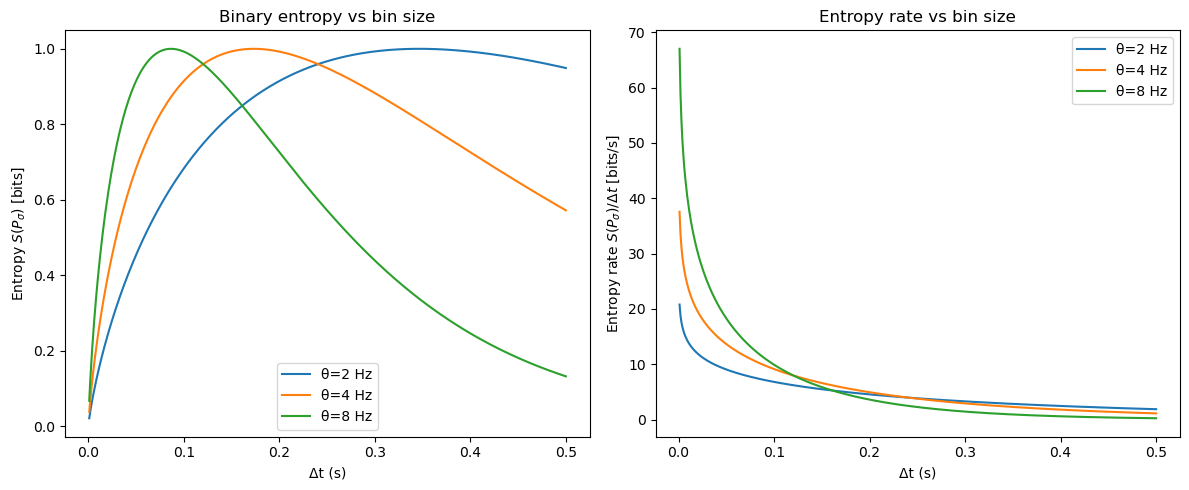

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


def xlogx(x):
    """Safe computation of x log(x), using scipy.special.xlogy to handle x=0."""
    return scipy.special.xlogy(x, x)


def binary_entropy(p):
    """Binary (Bernouilli) entropy in bits."""
    S = -xlogx(p) - xlogx(1 - p)
    return S / np.log(2)  # convert from nats to bits


def S_P_sigma(theta, dt):
    """
    Entropy S(P_sigma) in bits for a Poisson process binarized per bin.
    - Vectorized: works if theta or dt are scalars or arrays.
    - For each bin,  the entropy of a binarised Poisson process equals Bernoulli entropy with p = 1 - exp(-theta * dt).
    """
    ps = 1 - np.exp(-theta * dt)  # P(sigma=1)
    return binary_entropy(ps)


def plot_entropy_vs_dt(thetas, dts):
    """
    Plot entropy and entropy rate vs bin size for a list of firing rates.
    """
    plt.figure(figsize=(12,5))

    # (i) Entropy S(P_sigma)
    plt.subplot(1,2,1)
    for theta in thetas:
        S =  S_P_sigma(theta, dts)
        plt.plot(dts, S, label=f"θ={theta} Hz")

    plt.xlabel("Δt (s)")
    plt.ylabel(r"Entropy $S(P_\sigma)$ [bits]")
    plt.title("Binary entropy vs bin size")
    plt.legend()

    # (ii) Entropy rate S(P_sigma)/Δt
    plt.subplot(1,2,2)
    for theta in thetas:
        ps = 1 - np.exp(-theta * dts)
        H = binary_entropy(ps) / dts
        plt.plot(dts, H, label=f"θ={theta} Hz")
    plt.xlabel("Δt (s)")
    plt.ylabel(r"Entropy rate $S(P_\sigma)/\Delta t$ [bits/s]")
    plt.title("Entropy rate vs bin size")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- parameters ---
thetas = [2, 4, 8]  # Hz
dts = np.linspace(1e-3, 0.5, 500)  # bin sizes from 1 ms to 0.5 s

plot_entropy_vs_dt(thetas, dts)

---

## Part B - Entropy and information in experimental spike trains

We now move from the Poisson model to **real data**: the spiking activity of $L=40$ retinal ganglion cells, recorded during repeated presentations of a
natural movie stimulus [4].  This is the same dataset used in *Tutorial 1, Part B*. You can load it directly from the file `data/dati2-berry.dat` using:


In [12]:
# Number of neurons and stimulus repetitions
import numpy as np

N_rep  = 120
T_stim  = 26.5   # duration (s) of one stimulus repetition

def load_spike_data(path='data/dati2-berry.dat'):
    """
    Load and parse spike-train data from Schneidman et al. (2006).
    Each block in the file starts with a marker (4000), followed by
    the neuron ID, then the spike times (s).

    Returns
    -------
    datas : list of np.ndarray
        Spike times for each neuron (length L_neurons).
    """
    raw = np.loadtxt(path)
    chunks = np.split(raw, np.where(raw == 4000)[0][1:])
    data = [chunk[2:] for chunk in chunks]  # drop marker + neuron ID
    return data

# Load spike trains
data = load_spike_data()

N_neurons = len(data)
T_total = T_stim*N_rep # total recording time

print(f"Loaded {N_neurons} neurons, total duration {T_total:.1f}s")


Loaded 40 neurons, total duration 3180.0s


#### 🎯 Question B1.
 Discretize the spike train of each neuron into bins of length $\Delta t = 0.01\ \mathrm{s}$. Define a binary variable $\sigma \in \{0,1\}$ for each time bin, with $\sigma=1$ if at least one spike occurs, and $\sigma=0$ otherwise. The result should be a binary array `data_bin` of shape
$(N_{\text{neurons}},\, N_{\text{bins}})$, where $N_{\text{bins}} = N_{\text{rep}} T_{\text{stim}} / \Delta t$.

In [13]:
# --- Solution B1: Binarization of spike trains ---

import numpy as np

def binarize_spike_trains(data, T_total, dt, verbose=False):
    """
    Binarize spike trains for all neurons into time bins of width dt.

    Parameters
    ----------
    data : list of np.ndarray
        List of spike times for each neuron.
    T_total : float
        Total recording time (seconds).
    dt : float, optional
        Bin width in seconds.
    verbose : bool, optional
        If True, print summary information.

    Returns
    -------
    data_bin : np.ndarray
        Binarized spike matrix (neurons x bins).
    """

    # Determine the number of neurons from the data list
    N_neurons = len(data)
    # Compute the number of bins given the total time and bin width
    N_bins = int(T_total / dt)

    # Initialize the binary matrix (neurons x bins), filled with zeros
    data_bin = np.zeros((N_neurons, N_bins), dtype=int)

    # For each neuron, binarize its spike train
    for i in range(N_neurons):
        # Convert spike times to bin indices for this neuron
        spike_bins = (data[i] / dt).astype(int)
        # Mark bins containing at least one spike as 1
        data_bin[i, spike_bins] = 1

    if verbose:
        print(f"Binarized data shape: {data_bin.shape}")
        print(f"Fraction of nonzero entries: {data_bin.mean():.4f}")
        print("Example binarized spike train for neuron 0 (first 100 bins):")
        print(data_bin[0, :100])
    return data_bin

dt = 0.01  # bin size in seconds
data_bin = binarize_spike_trains(data, T_total, dt, verbose=True)


Binarized data shape: (40, 318000)
Fraction of nonzero entries: 0.0130
Example binarized spike train for neuron 0 (first 100 bins):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Word-based encoding

To quantify **reproducibility** and **information content** of neural responses, we need to move beyond single spikes or bins.   Instead, we represent the spike train as a sequence of **binary words**, which capture temporal patterns of activity over short time windows.  This approach allows us to compare not just firing rates, but the *structure* and *variability* of neural responses across repeated stimulus presentations.

Concretely, we split the spike train into non-overlapping binary words, whose associated random variable is $W$, each spanning a time window of length $L_W$ seconds and therefore extending over $l_W = L_W/\Delta t$ consecutive time bins. Let us call $\mathcal{W}$ the space of all possible binary words of length $l_W$. The number of possible words is: $N_{\mathrm{W}} = 2^{l_{W}}$.


**Example**. consider the following spike train, where each bin corresponds to $\Delta t = 0.01\ \mathrm{s}$:

[0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,(...)]

This can be split into words of length $L_W = 0.1\ \mathrm{s}$ (i.e. $l_W=10$ bins):

  - word 1: [0,1,1,1,0,0,1,0,1,0]
  - word 2: [0,0,0,1,0,1,0,1,0,1]
  - word 3: [0,1,0,1,0,1,0,1,0,1]
  - (...)

There are $N_W= 2^{l_W} = 2^{10} = 1024$ possible binary words of length $l_W$.

Given a spike train, we can estimate:
- The **total distribution** $P(W)$, i.e., relative frequency of each word across the full recording.
- The corresponding **total entropy**:
  $$
  S_{\mathrm{total}} \equiv S(W) = -\sum_{w\in\mathcal{W}} P(w) \log_2 P(w) \quad \text{bits}.
  $$

#### 🎯 Question B2.
For the first neuron, compute and print the total entropy $S_{\mathrm{total}}$ for $L_W = 0.1\ \mathrm{s}$ and $\Delta t = 0.01\ \mathrm{s}$.

In [14]:
# --- Solution B2: Total entropy of words  ---
dt = 0.01  # bin size in seconds
L_W = 0.1  # word length in seconds
l_W = int(L_W / dt)  # number of bins per word

def split_nonoverlapping_words(spike_train, l_W):
    """
    Split a 1D binary sequence (spike train for a single neuron) into consecutive **non-overlapping** words of length l_W.
    Truncates any trailing incomplete block.
    Returns: (n_words x l_W) array of 0/1.
    """

    # Compute the length to truncate so only full words are kept
    n_words = (len(spike_train) // l_W) * l_W
    # Truncate the spike train to a multiple of l_W
    row = spike_train[:n_words]

    # Reshape into (n_words, l_W)
    return row.reshape(-1, l_W)


def bits_to_int(words, l_W):
    """
    Convert an array of binary words (shape: n_words x l_W) into integers in [0, 2^l_W) - l_W is the legth (in bins) of the words.
    Vectorized: uses bit weights instead of strings.
    """

    # Create an array of bit weights: [2^(word_bins-1), ..., 2^0]
    weights = np.power(2, np.arange(l_W-1, -1, -1))

    # Compute the integer value for each word by dot product with weights.
    # For each row: sum(word[i] * weights[i]) over all bits.
    return (words @ weights).astype(int)


In [15]:
def empirical_word_distribution(word_ids, word_bins):
    """
    Compute the empirical distribution P(W) over all 2^word_bins possible words.

    Parameters
    ----------
    word_ids : np.ndarray
        Array of integer word IDs (each in [0, 2^word_bins)).
    word_bins : int
        Number of bins per word (word length).

    Returns
    -------
    probs : np.ndarray
        Probability of each word (length 2^word_bins).
    """
    # Compute the number of possible words (states) for the given word length
    n_states = 2**word_bins  # 2^word_bins

    # Count occurrences of each word ID
    # The use of minlength ensures that all possible words are represented (even if count is zero)
    counts = np.bincount(word_ids, minlength=n_states)

    # Normalize counts to obtain the empirical probability distribution
    probs = counts / counts.sum()

    # Return the probability of each word
    return probs

def compute_total_entropy(spike_train, l_W, dt):
    """
    Compute the total entropy S_total of the spike train of a single neuron.

    Parameters
    ----------
    spike_train : np.ndarray
        1D binary array (0/1) representing the spike train of a single neuron.
    l_W : int
        Number of bins per word (word length).
    dt : float
        Bin width in seconds.

    Returns
    -------
    S_total : float
        Total entropy S_total in bits.
    """
    # Split the spike train into non-overlapping words
    words_bits = split_nonoverlapping_words(spike_train, l_W)

    # Convert binary words to integer IDs
    word_ids = bits_to_int(words_bits, l_W)

    # Compute the empirical distribution P(W)
    probs = empirical_word_distribution(word_ids, l_W)

    # Compute the total entropy S_total (in bits)
    S_total = (-xlogx(probs).sum()) / np.log(2)

    return S_total

# Compute and print total entropy for the neuron labeled by 'idx'
idx = 0  # neuron index
S_tot_idx = compute_total_entropy(data_bin[idx], l_W, dt)
print(f"Total entropy for neuron {idx}: {S_tot_idx:.4f} bits")

Total entropy for neuron 0: 2.3067 bits


### Noise entropy and information

To assess how reproducible the neural responses are across repeated presentations of the same stimulus, we align trials and examine the distribution of words at each **word bin** - that is, each segment of the stimulus cycle of duration $L_W$ seconds, corresponding to a word of length $l_W$ time bins.

- If the neuron responds deterministically, the same word appears at each word bin on every trial.
- If responses vary across trials, the distribution of words at a given word bin broadens, reflecting noise in the response.

This motivates the definition of the **noise entropy**: the average uncertainty (entropy) of the word distribution when the word bin is fixed. Informally, it is the variability that does not come from that the variation of the stimulus.


Formally, let $B$ be the random variable denoting the **word bin** within a stimulus cycle. Here, each word bin corresponds to a specific stimulus, that is a specific moment of the replayed movie. $B$ takes values $b\in\mathcal{B}=\{0, 1, \ldots, N_B-1\}$, where $N_B = T_{\text{stim}}/L_W$ is the number of words that fit in one stimulus repetition. Since all word bins are equally likely, $P(B=b) = 1/N_B$. The conditional entropy of words given the word bin is defined as follows

  $$
    S(W\mid B) \equiv \sum_{b\in\mathcal{B}} p(b) S(W\mid B=b) = -\frac{1}{N_B} \sum_{b\in\mathcal{B}} \sum_{w\in\mathcal{W}} P(w \mid b)\,\log_2 P(w \mid b).
  $$

Here, $P(w\mid b)$ is the empirical distribution of words at word bin $b$ across stimulus repeats. This latter entropy is also called **noise entropy** $S_{\text{noise}}$ since it reflects the non-deterministic response to the stimulus.

- If responses are perfectly reproducible, each $P(w \mid b)$ is a delta distribution, so $S_{\text{noise}}=0$.
- Larger $S_{\text{noise}}$ means more variability across trials, i.e. less reproducibility.

The **mutual information** between the stimulus (represented by the word bin $B$) and the response (the word $W$) is defined as:

$$
I(W; B) \equiv S(W) - S(W \mid B)
$$

Thus, the **information** carried by the spike train about the stimulus is estimated as:

$$
I = S_{\text{total}} - S_{\text{noise}} \quad \text{(bits)}.
$$

- If \(I = 0\), the neural response carries no information about the stimulus (responses are independent of stimulus timing).
- Larger \(I\) indicates that spike patterns are more reproducible and stimulus-locked, hence more informative about the stimulus.

#### 🎯 Question B3.
Compute the noise entropy $S_{\text{noise}}$ and information $I$ for the first neuron, use $L_W = 0.1\ \mathrm{s}$ and $\Delta t = 0.01\ \mathrm{s}$.


In [16]:
# --- Solution B3: Noise entropy and information  ---

def spike_train_to_words(trial, l_W):
    """Convert one binary trial into a sequence of integer-coded words."""
    words_bits = split_nonoverlapping_words(trial, l_W)
    return bits_to_int(words_bits, l_W)


def compute_noise_entropy(spike_train, l_W, dt, T_stim, N_rep, average_over_bins=True):
    """
    Compute the noise entropy S_noise of the spike train of a single neuron.
    """

    # Number of time-bins per stimulus
    n_dt_stim = int(T_stim / dt)

    # Reshape spike train into (N_rep, N_bins_per_stim), each row is one trial
    spikes_by_stim = spike_train.reshape(N_rep, n_dt_stim)

    # Apply to each trial (row of spikes_by_stim)
    words_by_stim = np.apply_along_axis(spike_train_to_words, 1, spikes_by_stim, l_W)

    # Number of words per stimulus repetition T_stim/L_W
    N_B = int(T_stim / (l_W * dt))

    # Initialize array to hold entropy for each word bin
    S_B = np.zeros(N_B)

    for b in range(N_B):
        # Collect words at position b across repetitions
        word_ids = words_by_stim[:, b]
        # Compute empirical distribution P(W|B=b)
        probs = empirical_word_distribution(word_ids, l_W)
        # Compute entropy S(W|B=b) in bits
        S_B[b] = (-xlogx(probs).sum()) / np.log(2)  # entropy in bits

    if average_over_bins:
        # Average over time bins
        S_noise = S_B.mean()
    else:
        S_noise = S_B

    return S_noise

# Compute noise entropy for neuron idx
idx=0
S_noise_idx = compute_noise_entropy(data_bin[idx], l_W, dt, T_stim, N_rep)
I_idx = S_tot_idx - S_noise_idx
print(f"Noise entropy for neuron {idx}: {S_noise_idx:.4f} bits")
print(f"Mutual Information for neuron {idx}: {I_idx:.4f} bits")

Noise entropy for neuron 0: 1.4303 bits
Mutual Information for neuron 0: 0.8765 bits


#### 🎯 Question B4.
 Generalise the previous computations to all neurons and print the results in a table. Plot these three quantities ($S_{\text{total}}$, $S_{\text{noise}}$, $I$) as functions of the spiking frequency of each neuron. Compare to the total entropy rate of this process with the one of the binary process from Part A, briefly discuss why the entropy rate is the relevant quantity for comparison.

In [17]:
# --- Solution B4: All neurons ---

S_tot_all = np.apply_along_axis(compute_total_entropy, 1, data_bin, l_W, dt)
S_noise_all = np.apply_along_axis(compute_noise_entropy, 1, data_bin, l_W, dt, T_stim, N_rep)
I_all = S_tot_all - S_noise_all

header = f"{'Neuron':>7} {'S_total':>8}  {'S_noise':>8}  {'I (bits)':>8}"
print(header)
print("-" * len(header))

for i in range(len(S_tot_all)):
    print(f"{i:7d}  {S_tot_all[i]:8.3f}  {S_noise_all[i]:8.3f}  {I_all[i]:8.3f}")


 Neuron  S_total   S_noise  I (bits)
------------------------------------
      0     2.307     1.430     0.876
      1     0.436     0.249     0.188
      2     0.541     0.356     0.185
      3     0.393     0.233     0.161
      4     1.517     0.783     0.733
      5     1.527     0.770     0.758
      6     0.424     0.254     0.170
      7     0.907     0.550     0.357
      8     0.814     0.407     0.407
      9     1.686     0.927     0.759
     10     2.030     1.056     0.974
     11     1.924     1.025     0.900
     12     0.496     0.273     0.223
     13     0.634     0.415     0.219
     14     2.396     1.223     1.173
     15     1.022     0.570     0.452
     16     1.105     0.848     0.257
     17     0.256     0.126     0.130
     18     1.400     0.762     0.638
     19     0.411     0.241     0.170
     20     0.576     0.284     0.292
     21     0.516     0.339     0.177
     22     0.632     0.361     0.271
     23     0.692     0.344     0.348
     24     0.

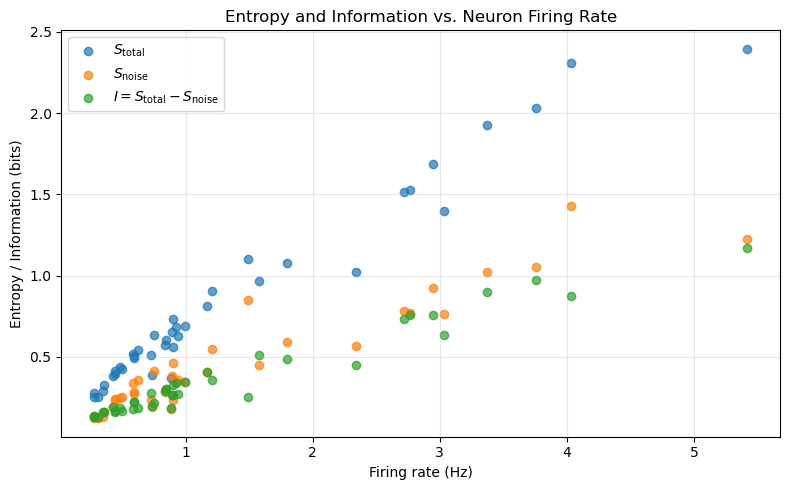

In [18]:
# Compute spiking frequency for each neuron (spikes per second)
firing_rates = np.array([len(d) for d in data]) / T_total

def plot_entropy_information_vs_firing_rate(firing_rates, S_tot_all, S_noise_all, I_all):
    """
    Plot S_total, S_noise, and I vs firing rate for a set of neurons.

    Parameters
    ----------
    firing_rates : np.ndarray
        Array of firing rates (Hz) for each neuron.
    S_tot_all : np.ndarray
        Total entropy for each neuron.
    S_noise_all : np.ndarray
        Noise entropy for each neuron.
    I_all : np.ndarray
        Information (S_total - S_noise) for each neuron.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(firing_rates, S_tot_all, label="$S_{\\mathrm{total}}$", alpha=0.7)
    plt.scatter(firing_rates, S_noise_all, label="$S_{\\mathrm{noise}}$", alpha=0.7)
    plt.scatter(firing_rates, I_all, label="$I = S_{\\mathrm{total}} - S_{\\mathrm{noise}}$", alpha=0.7)
    plt.xlabel("Firing rate (Hz)")
    plt.ylabel("Entropy / Information (bits)")
    plt.title("Entropy and Information vs. Neuron Firing Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_entropy_information_vs_firing_rate(firing_rates, S_tot_all, S_noise_all, I_all)


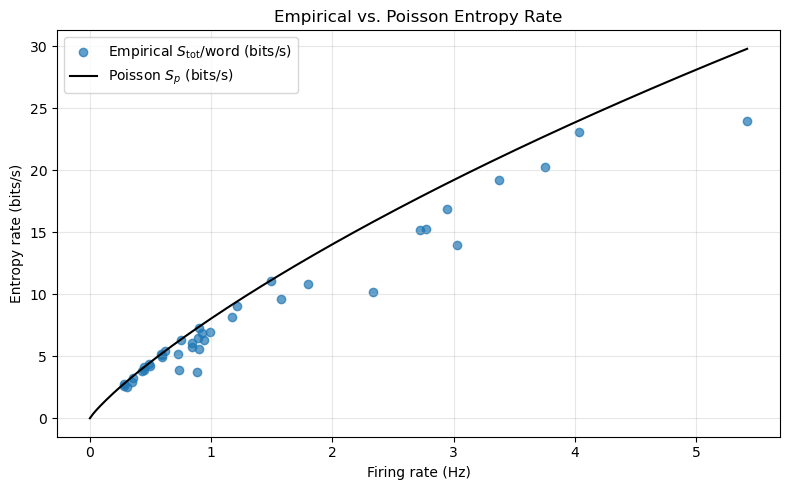

In [25]:
def plot_empirical_vs_poisson_entropy_rate(firing_rates, S_tot_all, l_W, dt):
    """
    Plot empirical entropy rate vs. theoretical Poisson entropy rate.

    Parameters
    ----------
    firing_rates : np.ndarray
        Firing rates (Hz) for each neuron.
    S_tot_all : np.ndarray
        Total entropy for each neuron (bits).
    l_W : int
        Number of bins per word.
    dt : float
        Bin width (s).
    """

    def Sp(f, dt):
        p = np.exp(-f * dt)
        return binary_entropy(p)

    empirical_entropy_rate = S_tot_all / (l_W * dt)
    thetas = np.linspace(0, firing_rates.max(), 200)
    theoretical_entropy_rate = Sp(thetas, dt)/ dt

    plt.figure(figsize=(8, 5))
    plt.scatter(firing_rates, empirical_entropy_rate, label="Empirical $S_{\\mathrm{tot}}$/word (bits/s)", alpha=0.7)
    plt.plot(thetas, theoretical_entropy_rate, label="Poisson $S_p$ (bits/s)", color="k")
    plt.xlabel("Firing rate (Hz)")
    plt.ylabel("Entropy rate (bits/s)")
    plt.title("Empirical vs. Poisson Entropy Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_empirical_vs_poisson_entropy_rate(firing_rates, S_tot_all, l_W, dt)

#### 🎯 Question B5.
For the first neuron, compute the **noise entropy** $S_{\mathrm{noise}}(b)$ **for each word bin** $b$ within the stimulus cycle (without averaging across bins).  

Plot these entropy values as a function of the **average firing rate** in each bin. On the same figure, overlay the theoretical prediction for a Poisson process with the same (word) bin rates, computed over $l_W$ time bins, namely $l_W \, S(P_{\sigma})$, where $S(P_{\sigma})$ is the binary entropy introduced in Part A1.

**Discussion:** Comment on how the measured noise entropy compares to the Poisson prediction: what does this tell us about the structure of the neural responses relative to a homogeneous Poisson model? 


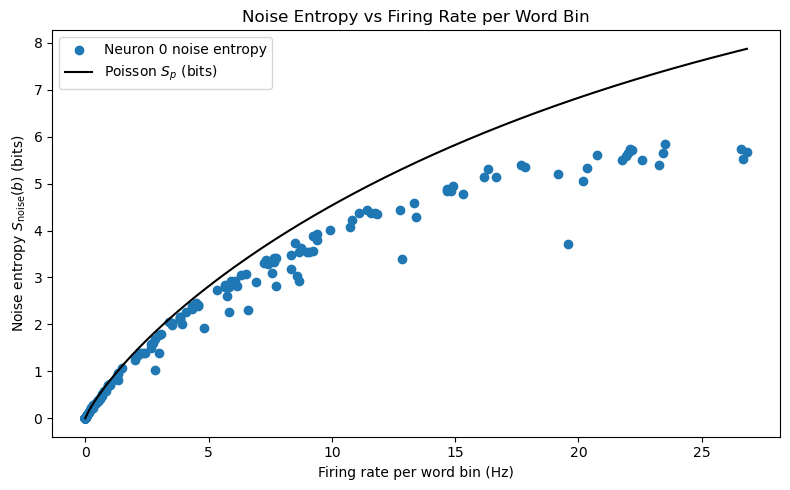

In [20]:
# --- Solution B5: Noise entropy vs theoretical prediction --

def compute_per_bin_firing_rates(spike_times, N_rep, T_stim, L_W):
    """
    Compute average firing rate (Hz) for a single neuron in each word bin of a stimulus cycle.

    Parameters
    ----------
    spike_times : np.ndarray
        1D array of spike times (s) for a single neuron.
    N_rep : int
        Number of stimulus repetitions.
    T_stim : float
        Duration of one stimulus repetition (s).
    L_W : float
        Word bin length (s).

    Returns
    -------
    freqs_b : np.ndarray
        Array of firing rates (Hz) for each bin.
    """
    # Compute the start times of each word bin within a stimulus cycle
    ts = np.arange(0, T_stim, L_W)
    # Initialize array to hold firing rates for each bin
    freqs_b = np.zeros(len(ts))

    # Find the bin index for each spike (modulo stimulus cycle)
    t_index, t_count = np.unique((spike_times % T_stim) // L_W, return_counts=True)
    # Assign spike counts to the corresponding bins
    freqs_b[t_index.astype(int)] = t_count

    # Convert spike counts to firing rates (Hz) by dividing by total time per bin
    freqs_b /= (N_rep * L_W)

    return freqs_b


idx = 0

# Get spike train (binarised) for neuron idx
spike_train = data_bin[idx]
# Compute noise entropy for each word bin (without averaging)
S_noise_b = compute_noise_entropy(spike_train, l_W, dt, T_stim, N_rep, average_over_bins=False)

# Get original spike times for neuron idx
spike_times = data[idx]
# Compute firing rates per word bin for all neurons
freqs_b = compute_per_bin_firing_rates(spike_times, N_rep, T_stim, L_W)

thetas = np.linspace(0, freqs_b.max(), 200)
# Compute theoretical Poisson entropy rate for comparison - use the S_P_sigma from Part A
theoretical_entropy_rate = l_W*S_P_sigma(thetas, 0.01)

plt.figure(figsize=(8, 5))
plt.scatter(freqs_b, S_noise_b, label=f"Neuron {idx} noise entropy")
plt.plot(thetas, theoretical_entropy_rate, label="Poisson $S_p$ (bits)", color="k")
plt.xlabel("Firing rate per word bin (Hz)")
plt.ylabel("Noise entropy $S_{\\mathrm{noise}}(b)$ (bits)")
plt.title("Noise Entropy vs Firing Rate per Word Bin")
plt.legend()
plt.tight_layout()
plt.show()

**Discussion:** The measured noise entropy is consistently lower than the Poisson prediction, particularly at higher firing rates. This means the neural responses are more reliable and less variable than would be expected from a homogeneous Poisson process, where spikes occur independently in each time bin.

Since entropy is maximized for independent processes (see Theorem 2.6.6 in [5]), the lower observed entropy suggests that the neural responses exhibit temporal correlations and structured patterns, reducing variability across trials.

#### 🎯 Question B6 (Optional).
 Investigate how the estimated information $I$ depends on two key parameters:

1. The number of stimulus repetitions $N_{\text{rep}}$.
2. The word duration $L_W$ (in seconds).

For the first neuron:
- Compute the information $I$ as a function of $N_{\text{rep}}$ and $L_W$.
- Express the result both as **bits per word** and as **bits per second**.
- Examine whether the information per second converges as $N_{\text{rep}}$ and $L_W$ increase.

**Discussion:** Are the available data $(N_{\text{rep}}=120$ and word size $L_W = 0.1\,\mathrm{s}$) sufficient to obtain a reliable estimate of the information rate?

In [21]:
# --- Solution B6: Varying parameters --

def compute_information(spike_train, L_W=0.1, N_rep=120, dt=0.01, T_stim=26.5):
    """
    Compute the information I = S_total - S_noise for a single neuron.
    """
    l_W = int(L_W/dt)
    S_total = compute_total_entropy(spike_train, l_W, dt)
    S_noise = compute_noise_entropy(spike_train, l_W, dt, T_stim, N_rep)
    I = S_total - S_noise
    return I

idx = 0
spike_train = data_bin[idx]

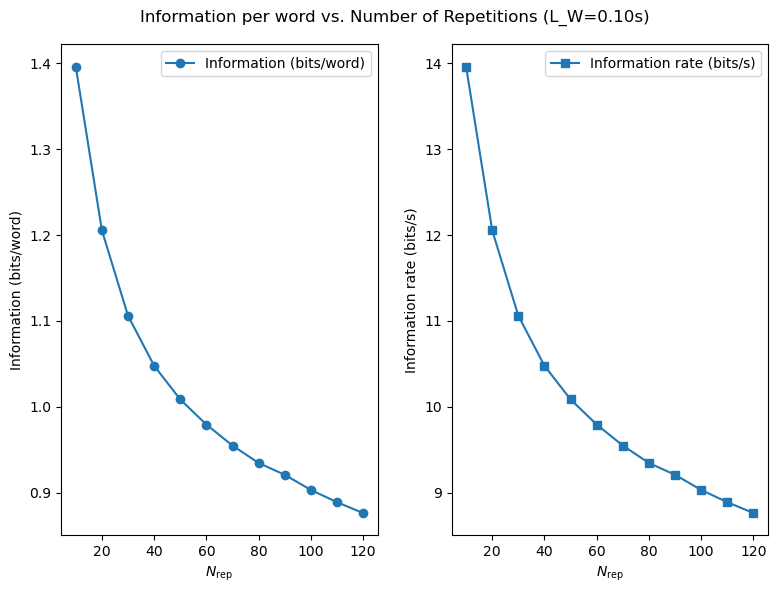

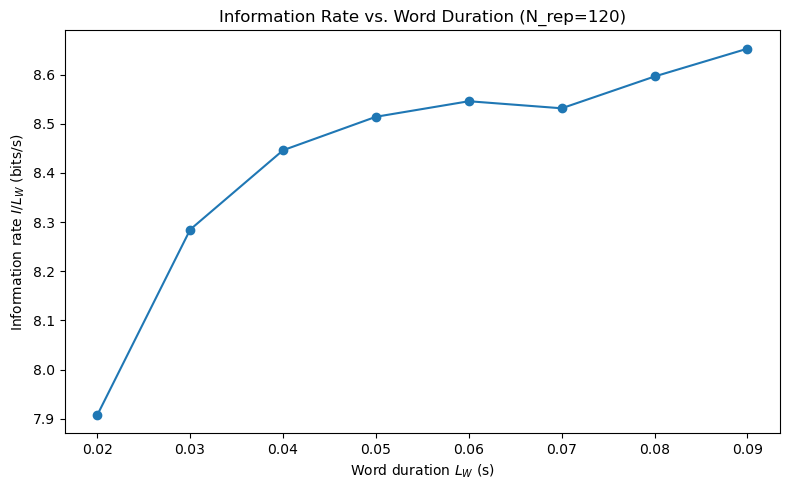

In [22]:
def plot_information_vs_nrep(spike_train):
    """
    Plot information per word (bits/word) and information rate (bits/s)
    as a function of N_rep for a fixed word duration L_W.
    """
    N_rep_values = np.arange(10, 130, 10)  # 10,20,...120
    I_bits_per_sec = []
    I_bits_per_word = []

    # Use global L_W, dt, T_stim if not passed as arguments
    n_dt_stim = int(T_stim / dt)

    for N_rep in N_rep_values:
        spike_train_subset = spike_train[:int(N_rep * n_dt_stim)]
        I = compute_information(spike_train_subset, L_W=L_W, N_rep=N_rep, dt=dt, T_stim=T_stim)
        I_bits_per_word.append(I)
        I_bits_per_sec.append(I / L_W)

    fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True)
    fig.suptitle(f"Information per word vs. Number of Repetitions (L_W={L_W:.2f}s)")

    # Top: Information per word
    axes[0].plot(N_rep_values, I_bits_per_word, marker='o', label="Information (bits/word)")
    axes[0].set_xlabel(r"$N_{\mathrm{rep}}$")
    axes[0].set_ylabel("Information (bits/word)")
    axes[0].legend()

    # Bottom: Information rate
    axes[1].plot(N_rep_values, I_bits_per_sec, marker='s', label="Information rate (bits/s)")
    axes[1].set_xlabel(r"$N_{\mathrm{rep}}$")
    axes[1].set_ylabel("Information rate (bits/s)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_information_vs_nrep(spike_train)



def plot_information_vs_L_W(spike_train, N_rep=120):
    """
    Plot information rate (bits/s) as a function of word duration L_W.
    """
    eps = 1e-5  # small offset to avoid zero
    L_W_values = np.arange(0.02+eps, .10, 0.01)  # word durations from 20 ms to 2 s
    I_bits_per_sec = []

    n_dt_stim = int(T_stim / dt)

    # Use only the first N_rep repetitions
    spike_train_subset = spike_train[:int(N_rep * n_dt_stim)]

    for L_W in L_W_values:
        I = compute_information(spike_train_subset, L_W=L_W, N_rep=N_rep, dt=dt, T_stim=T_stim)
        I_bits_per_sec.append(I / L_W)

    plt.figure(figsize=(8, 5))
    plt.plot(L_W_values, I_bits_per_sec, marker='o')
    plt.xlabel(r"Word duration $L_W$ (s)")
    plt.ylabel("Information rate $I/L_W$ (bits/s)")
    plt.title(f"Information Rate vs. Word Duration (N_rep={N_rep})")
    plt.tight_layout()
    plt.show()

plot_information_vs_L_W(spike_train)